Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.035022 s



C:\Users\rasik\New folder\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.220992 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.31e-02, 8.68e+04, 2.46e+05]    [1.37e-02, 8.68e+04, 2.46e+05]    []  
1000      [1.45e+01, 4.50e+03, 1.19e+04]    [1.52e+01, 4.50e+03, 1.19e+04]    []  
2000      [2.53e+00, 1.11e+00, 5.19e+00]    [2.65e+00, 1.11e+00, 5.19e+00]    []  
3000      [2.25e+00, 3.90e-01, 2.86e+00]    [2.29e+00, 3.90e-01, 2.86e+00]    []  
4000      [1.82e+00, 1.05e-01, 1.52e+00]    [1.92e+00, 1.05e-01, 1.52e+00]    []  
5000      [1.51e+00, 1.74e-02, 7.74e-01]    [1.54e+00, 1.74e-02, 7.74e-01]    []  
6000      [1.21e+00, 5.82e-03, 3.62e-01]    [1.24e+00, 5.82e-03, 3.62e-01]    []  
7000      [9.56e-01, 1.25e-03, 1.29e-01]    [9.49e-01, 1.25e-03, 1.29e-01]    []  
8000      [7.77e-01, 2.25e-04, 3.98e-02]    [7.57e-01, 2.25e-04, 3.98e-02]    []  
9000      [6.77e-01, 2.60e-03, 1.87e-02]    [6.33e-01, 2.60e-03, 1.87e-02]    []  
10000     [6.32e-01, 1.31e-03, 6.6

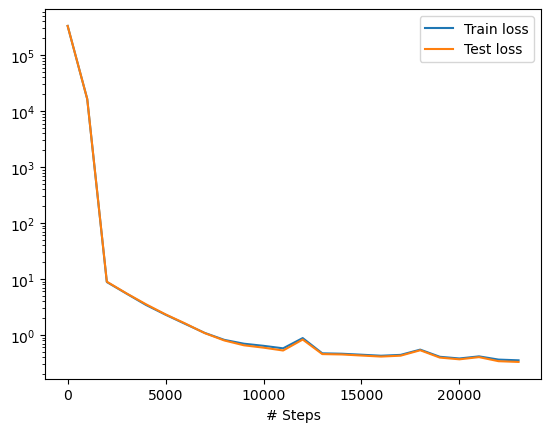

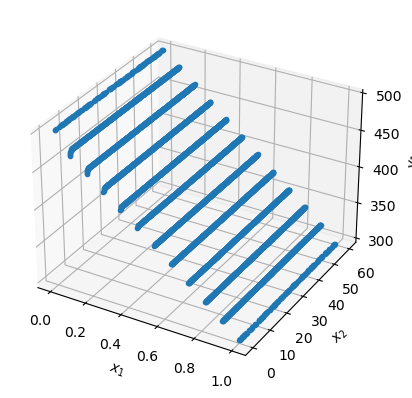

In [1]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Problem parameters
a = 1    # Thermal diffusivity
L = 1    # Length of the interval

# PDE residual
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    return du_t - a * du_xx

# Computational geometry: Interval x TimeDomain
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 60)    # time domain from 0 to 1
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Boundary conditions
def boundary_r (x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], L)
def boundary_l (x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)


# Boundary conditions:
bc_l = dde.DirichletBC(geomtime, lambda x: 500, boundary_l)                #Dirichlet (constant temperature)
bc_r = dde.DirichletBC(geomtime, lambda x: 298, boundary_r)                #Dirichlet (constant temperature)
ic = dde.IC(geomtime, lambda x: 298, lambda _, on_initial: on_initial)

# Data
data = dde.data.TimePDE(
    geomtime, 
    pde, 
    [bc_r, bc_l],
    num_domain=5000,
    num_boundary=285,
    num_initial=300,
    num_test=5000,
)

# Neural network
layer_size = [2] + [20] * 3 + [1]
activation = "relu"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

# Model
model = dde.Model(data, net)

# Compile and train
model.compile("adam", lr=1e-3)
model.train(iterations=23000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Plot results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)







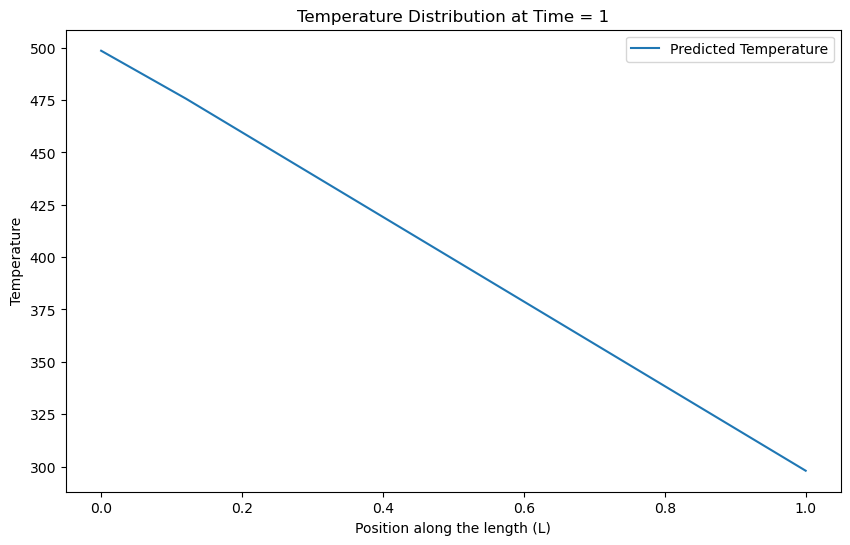

In [2]:
# Test set
x = np.linspace(0, L, 250)  # 100 points along the length
specific_time = 1         # time 
test_set = np.array([[xi, specific_time] for xi in x])

# Making predictions
y_pred = model.predict(test_set)
temperature_pred = y_pred[:, 0]  

# Plotting the temperature distribution
plt.figure(figsize=(10, 6))
plt.plot(x, temperature_pred, label='Predicted Temperature')
plt.xlabel('Position along the length (L)')
plt.ylabel('Temperature')
plt.title('Temperature Distribution at Time = 1')
plt.legend()
plt.show()

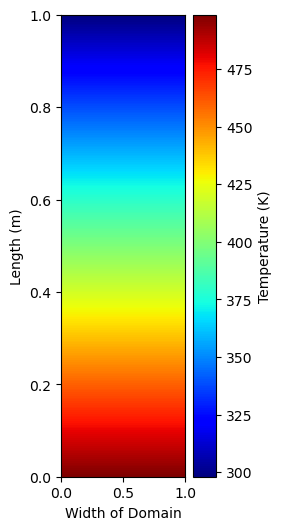

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `model` has been trained and `L` is the length of the domain.
# Generate a grid of points along the length
x = np.linspace(0, L, 256)
t = np.full_like(x, 1)  # for t = 15 minutes, converted to seconds
X = np.vstack((x, t)).T

# Predict the temperature distribution using the trained model
u_pred = model.predict(X)

# Plot the results
plt.figure(figsize=(2, 6))
plt.imshow(u_pred.reshape((256, 1)), extent=[0, 1, 0, L], origin="lower", aspect="auto",cmap='jet')
plt.colorbar(label='Temperature (K)')
#plt.title("Temperature Distribution at t = 15 min")
plt.xlabel("Width of Domain")
plt.ylabel("Length (m)")
plt.show()
